Jako zmienne objaśniąjące użyłem poniższe wskaźniki ekonomiczne

1. wskaźnik polskiego agregatu pieniężnego m3 (annual rate of change) https://www.nbp.pl/home.aspx?f=/statystyka/pieniezna_i_bankowa/m3.html
4. pkb kwartalne (annual rate of change) https://fred.stlouisfed.org/series/NAEXKP02PLQ659S
3. polska stopa referencyjna (annual rate of change) - https://www.nbp.pl/home.aspx?f=/dzienne/stopy_archiwum.htm

m3 - inflacja jest powodowana przez wzrost podaży pieniądza, który prowadzi do wzrostu popytu agregatowego. Im wyższy wskaźnik nominalnej podaży pieniądza, tym wyższy jest wskaźnik inflacji. 

polityka taniego pieniądza - inaczej polityka ekspansji kredytowej tj. niskich stóp procentowych prowadzi do zwiększa popyt na dobra i usługi. Wraz ze wzrastającą ekspansją kredytową, wzrasta dochód pieniężny kredytobiorców, co z kolei podnosi popyt w stosunku do podaży, prowadząc w ten sposób do inflacji (credit inducted inflation).

pkb - wzrost produktu krajowego brutto ceteris paribus spowoduje wzrost przeciętnej stopy procentowej. W przeciwnej sytuacji, recesja ceteris paribus spowoduje spadek przeciętnej stopy procentowej. To oczywiście ma pośredni wpływ na inflację


Z powyższych powodów zdecydowałem się na powyższe zmienne jednak najważniejszym powodem była dostępność danych w internecie. Pierwotnie chciałem użyć jako zmienne objaśniające takie wskaźniki jak:

* dochód dyspozycyjny europejczyka per capita
* wzrost publicznych wydatków
* wzrost exportu

Niestety nie mogłem znaleźć powyższych danych w ujęciu miesięcznym oraz w okresie mnie interesującym. Prawdopodobnie powyższe dane znacznie by ulepszyły model.

## Import danych

In [ ]:
import os
import pandas as pd

os.getcwd()

'/content'

In [ ]:
inf = pd.read_excel('inflacja.xlsx')
int_rate = pd.read_excel('pl_reference_rate_change.xlsx')
m3 = pd.read_excel('pl_m3_change.xlsx')
gdp = pd.read_excel('pl_gdp_q_change.xls')

print(inf)
print(int_rate)
print(m3)
print(gdp)

          date  inf
0   2021-10-01  4.7
1   2021-09-01  4.2
2   2021-08-01  3.6
3   2021-07-01  2.8
4   2021-06-01  1.6
..         ...  ...
233 2002-05-01 -1.6
234 2002-04-01  1.4
235 2002-03-01  2.6
236 2002-02-01  2.8
237 2002-01-01  2.5

[238 rows x 2 columns]
          date  int_rate
0   2021-11-01    613.64
1   2021-10-01    177.27
2   2021-09-01      4.35
3   2021-08-01     -8.70
4   2021-07-01    -16.00
..         ...       ...
258 2000-05-01     40.35
259 2000-04-01     38.73
260 2000-03-01     39.38
261 2000-02-01     34.64
262 2000-01-01     16.16

[263 rows x 2 columns]
          date         m3
0   2021-10-01   8.587052
1   2021-09-01   8.627043
2   2021-08-01   9.085902
3   2021-07-01   8.828363
4   2021-06-01   7.431788
..         ...        ...
257 2000-05-01  15.357517
258 2000-04-01  15.361801
259 2000-03-01  13.955577
260 2000-02-01  13.368066
261 2000-01-01  15.329778

[262 rows x 2 columns]
          date        gdp
0   2021-05-01        NaN
1   2021-04-01  13.41892

zmiana na dat na datetime

In [ ]:
m3['date'] = m3['date'].apply(lambda x: pd.to_datetime(x))
gdp['date'] = gdp['date'].apply(lambda x: pd.to_datetime(x))
int_rate['date'] = int_rate['date'].apply(lambda x: pd.to_datetime(x))
inf['date'] = inf['date'].apply(lambda x: pd.to_datetime(x))

sprawdzanie pustych komórek

In [ ]:
inf.isna().sum()

date    0
inf     0
dtype: int64

In [ ]:
m3.isna().sum()

date    0
m3      0
dtype: int64

In [ ]:
gdp.isna().sum()

date      0
gdp     171
dtype: int64

W gdp użyłem danych kwartalnych (innych nie mogłem znaleźć) brakujące miesiące wypełnie interpolacją.

In [ ]:
gdp['gdp'].interpolate(method='linear', inplace = True)
gdp.isna().sum()

date    0
gdp     1
dtype: int64

In [ ]:
gdp.dropna(inplace = True)
gdp.isna().sum()

date    0
gdp     0
dtype: int64

In [ ]:
int_rate.isna().sum()

date        0
int_rate    0
dtype: int64

brak brakujących danych

merge

In [ ]:
df = inf.merge(m3, how = 'left', left_on = 'date', right_on = 'date')
df = df.merge(gdp, how = 'left', left_on = 'date', right_on = 'date')
df = df.merge(int_rate, how = 'left', left_on = 'date', right_on = 'date')

In [ ]:
df.isna().sum()

date        0
inf         0
m3          0
gdp         6
int_rate    0
dtype: int64

In [ ]:
df.head(10)

,date,inf,m3,gdp,int_rate
0,2021-10-01,4.7,8.587052,NaN,177.27
1,2021-09-01,4.2,8.627043,NaN,4.35
2,2021-08-01,3.6,9.085902,NaN,-8.70
3,2021-07-01,2.8,8.828363,NaN,-16.00
4,2021-06-01,1.6,7.431788,NaN,-22.22
5,2021-05-01,1.5,8.968216,NaN,-68.18
6,2021-04-01,1.2,11.166167,13.418929,-74.70
7,2021-03-01,0.6,14.368704,8.814145,-85.52
8,2021-02-01,0.7,16.286770,4.209362,-87.72
9,2021-01-01,0.9,16.845134,-0.395421,-87.72


Wypełniam puste miejsca w gdp ostatnią wartością

In [ ]:
df['gdp'].fillna(method='bfill', inplace = True)
df.isna().sum()

date        0
inf         0
m3          0
gdp         0
int_rate    0
dtype: int64

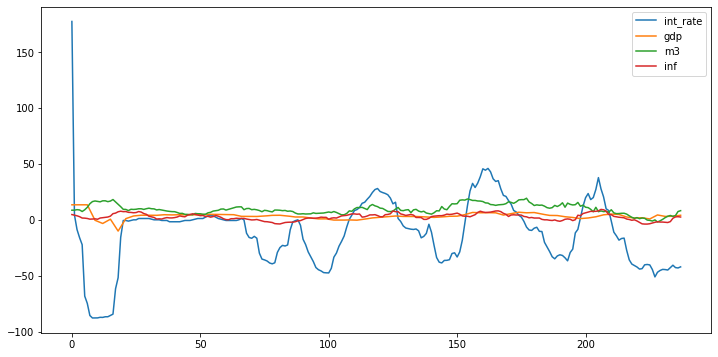

In [ ]:
df['int_rate'].plot(figsize = (12,6), legend = True)
df['gdp'].plot(figsize = (12,6), legend = True)
df['m3'].plot(figsize = (12,6), legend = True)
df['inf'].plot(figsize = (12,6), legend = True)

Trend zmiennej objaśnianej inf

In [ ]:
import plotly.express as px

t = 'plotly_dark'

px.line(df, df['date'], df['inf'], template = t, title = 'Roczna zmiana cen żywności i napoi bezalkoholowych')

## 1. Dyskusja na temat doboru zmiennych objaśniających

### Wszystkie zmienne

In [ ]:
cols = list(df.columns[1:-1])

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x= df['date'], y= df['inf'],mode='lines', name= 'Y'))

for i in cols:
    col = '{}'.format(i)
    fig.add_trace(go.Scatter(x=df['date'], y= df[col], mode='lines', name= i, opacity = 0.4))

fig.update_layout(template = t)

fig.show()

### Korelacje

In [ ]:
df.corr()[['inf']].sort_values(by = 'inf', ascending = False).iloc[1:,:]

,inf
int_rate,0.510974
m3,0.368093
gdp,-0.001702


### Test t-studenta

In [ ]:
from scipy import stats

stats.ttest_ind(df['m3'],df['inf'])

Ttest_indResult(statistic=20.062774263089022, pvalue=2.8658499181039514e-65)

In [ ]:
stats.ttest_ind(df['gdp'],df['inf'])

Ttest_indResult(statistic=2.865151052776032, pvalue=0.004353282261031207)

In [ ]:
stats.ttest_ind(df['int_rate'],df['inf'])

Ttest_indResult(statistic=-7.316834011093433, pvalue=1.0929425055210584e-12)

Biorąc pod uwagę alfa = 0.05 oraz test t-studenta wszystkie zmienne wykazują p-value na poziomie niższym niż alfa zatem w trzech przypadkach możemy odrzucić hipotezę H0 na rzecz H1 i stwierdzić, że wszystkie zmienne są istotne względem zmiennej objaśnianej. P-value jest tak niskie (w praktyce można przyrównać do zera), że przyjęte alfa mogłoby być znacznie niższe.

In [ ]:
df = df[['date','m3','gdp','int_rate','inf']]
df

,date,m3,gdp,int_rate,inf
0,2021-10-01,8.587052,13.418929,177.27,4.7
1,2021-09-01,8.627043,13.418929,4.35,4.2
2,2021-08-01,9.085902,13.418929,-8.70,3.6
3,2021-07-01,8.828363,13.418929,-16.00,2.8
4,2021-06-01,7.431788,13.418929,-22.22,1.6
...,...,...,...,...,...
233,2002-05-01,3.882299,3.142500,-42.66,-1.6
234,2002-04-01,3.050481,3.190603,-40.56,1.4
235,2002-03-01,3.830342,3.487222,-42.70,2.6
236,2002-02-01,7.412921,3.783841,-43.01,2.8


## 2. Opis transformacji zmiennych 

### Standaryzacja

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_data = scaler.fit_transform(df.iloc[:,1:]) # standaryzuje wyszystkie kolumny oprócz daty
scaled_data = pd.DataFrame(data = scaled_data, columns = list(df.columns)[1:]) # tworzę data frame
scaled_data[:5]

,m3,gdp,int_rate,inf
0,-0.193958,3.493343,6.183387,0.717002
1,-0.184757,3.493343,0.534242,0.545395
2,-0.079182,3.493343,0.107910,0.339466
3,-0.138437,3.493343,-0.130575,0.064894
4,-0.459763,3.493343,-0.333777,-0.346965


In [ ]:
scaled_data.insert(loc=0, column='date', value=df[['date']])
df = scaled_data
df.head(3)

,date,m3,gdp,int_rate,inf
0,2021-10-01,-0.193958,3.493343,6.183387,0.717002
1,2021-09-01,-0.184757,3.493343,0.534242,0.545395
2,2021-08-01,-0.079182,3.493343,0.107910,0.339466


### Outliers detection & rejection

Do detekcji anomalii użyje biblioteki stworzonej przez Facebooka Prophet

In [ ]:
df.head()

,date,m3,gdp,int_rate,inf
0,2021-10-01,-0.193958,3.493343,6.183387,0.717002
1,2021-09-01,-0.184757,3.493343,0.534242,0.545395
2,2021-08-01,-0.079182,3.493343,0.107910,0.339466
3,2021-07-01,-0.138437,3.493343,-0.130575,0.064894
4,2021-06-01,-0.459763,3.493343,-0.333777,-0.346965


Jako, że mamy 4 zmienne dla każdej oddzielnie usunę anomalie

In [ ]:
# przygotowanie danych do przeprocesowania przez Propheta
# Prophet wymaga dwóch kolumn o nazwach ds (datestamp) oraz y dlatego zamieniam nazwy kolumn

# m3
m3_df = df.iloc[:,:2]
m3_df.columns = ['ds','y'] 
# gdp
temp_df = pd.DataFrame(df.iloc[:,2])
gdp_df = pd.DataFrame(df.iloc[:,0])
gdp_df['gdp'] = temp_df
gdp_df.columns = ['ds','y']
# int_rate
temp_df = pd.DataFrame(df.iloc[:,3])
int_rate_df = pd.DataFrame(df.iloc[:,0])
int_rate_df['int_rate'] = temp_df
int_rate_df.columns = ['ds','y']
# inf
temp_df = pd.DataFrame(df.iloc[:,-1])
inf_df = pd.DataFrame(df.iloc[:,0])
inf_df['inf'] = temp_df
inf_df.columns = ['ds','y']

In [ ]:
def outlier_detection(df):
  from fbprophet import Prophet

  model = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=False, interval_width=0.99, changepoint_range=0.8)

  model.fit(df)
  forecast = model.predict(df)[['ds','trend','yhat_lower','yhat_upper']] 
  # jeżeli punkt nie wpada pomiędzy yhat_lower a yhat_upper uznaje go za outliera
  forecast['real'] = df['y']
  forecast['outlier'] = 1 # 1 oznacza, że punkt NIE jest anomalią

  forecast.loc[forecast['real'] > forecast['yhat_upper'], 'outlier'] = -1
  forecast.loc[forecast['real'] < forecast['yhat_lower'], 'outlier'] = -1

  return forecast

In [ ]:
m3_data = outlier_detection(m3_df)
px.scatter(m3_data, x = 'ds', y='real', color = 'outlier', color_continuous_scale = 'Bluyl', title = 'M3 - Anomaly Detection in Time Series', template = 'plotly_dark', width = 950, height = 500)

In [ ]:
gdp_data = outlier_detection(gdp_df)
px.scatter(gdp_data, x = 'ds', y='real', color = 'outlier', color_continuous_scale = 'Bluyl', title = 'GDP - Anomaly Detection in Time Series', template = 'plotly_dark', width = 950, height = 500)

Widać dużą anomalię spowodowaną globalną pandemią COVID-19

In [ ]:
int_rate_data = outlier_detection(int_rate_df)
px.scatter(int_rate_data, x = 'ds', y='real', color = 'outlier', color_continuous_scale = 'Bluyl', title = 'INT_RATE = Anomaly Detection in Time Series', template = 'plotly_dark', width = 950, height = 500)

Widoczne anomalie w okolicy kryzysu finansowego kredytów hipotecznych

In [ ]:
inf_data = outlier_detection(inf_df)
px.scatter(inf_data, x = 'ds', y='real', color = 'outlier', color_continuous_scale = 'Bluyl', title = 'INF - Anomaly Detection in Time Series', template = 'plotly_dark', width = 950, height = 500)

Zamiast outlierów wstawię nan

In [ ]:
# funkcja zamieniająca real na nan gdy jest outlierem
import numpy as np

def outliers_nan(real, outlier):

  if outlier == -1:
    return np.nan
  else:
    return real

In [ ]:
# uruchomienie funkcji

m3_data['real'] = m3_data.apply(lambda x: outliers_nan(x.real, x.outlier), axis=1)
gdp_data['real'] = gdp_data.apply(lambda x: outliers_nan(x.real, x.outlier), axis=1)
int_rate_data['real'] = int_rate_data.apply(lambda x: outliers_nan(x.real, x.outlier), axis=1)
inf_data['real'] = inf_data.apply(lambda x: outliers_nan(x.real, x.outlier), axis=1)

In [ ]:
# transformacja df

m3_data = m3_data[['ds','real']]
m3_data.columns = ['date','m3']

gdp_data = gdp_data[['ds','real']]
gdp_data.columns = ['date','gdp']

int_rate_data = int_rate_data[['ds','real']]
int_rate_data.columns = ['date','int_rate']

inf_data = inf_data[['ds','real']]
inf_data.columns = ['date','inf']

In [ ]:
print(m3_data.isna().sum())
print('\n')
print(gdp_data.isna().sum())
print('\n')
print(int_rate_data.isna().sum())
print('\n')
print(inf_data.isna().sum())

date    0
m3      4
dtype: int64


date     0
gdp     10
dtype: int64


date        0
int_rate    3
dtype: int64


date    0
inf     3
dtype: int64


Takim sposobem w miejsce outlierów wstawiłem NAN. Teraz ponownie za pomoca interpolacji wypełnię puste miejsca liniową funkcją. Powyżej widzimy ile mamy pustych komórek w każdym zestawie danych

##### M3

Przed detekcą

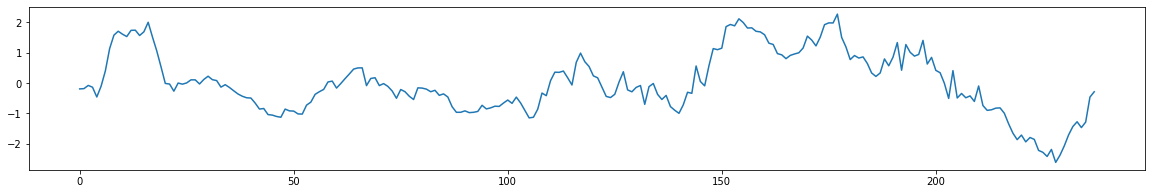

In [ ]:
df['m3'].plot(figsize = (20,3))

Po usunięciu outlierów

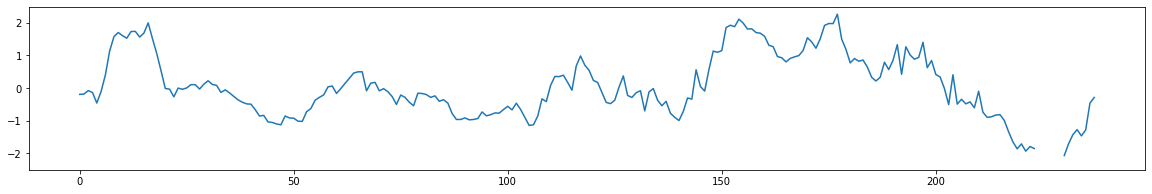

In [ ]:
m3_data['m3'].plot(figsize = (20,3))
m3_data['m3'].interpolate(method='linear', inplace = True)

Po interpolacji

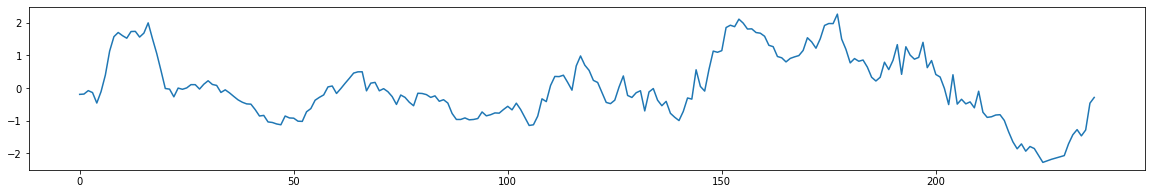

In [ ]:
m3_data['m3'].plot(figsize = (20,3))

##### GDP

Przed usunięciem outlierów

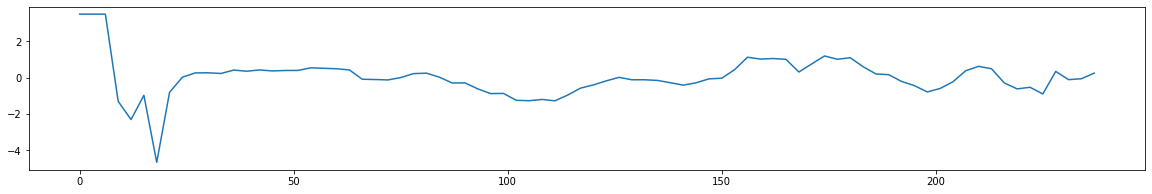

In [ ]:
df['gdp'].plot(figsize = (20,3))

Po usunięciu outlierów

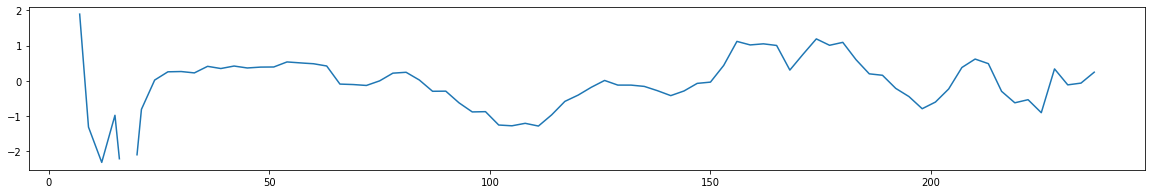

In [ ]:
gdp_data['gdp'].plot(figsize = (20,3))
gdp_data['gdp'].interpolate(method='linear',inplace = True)

Po interpolacji

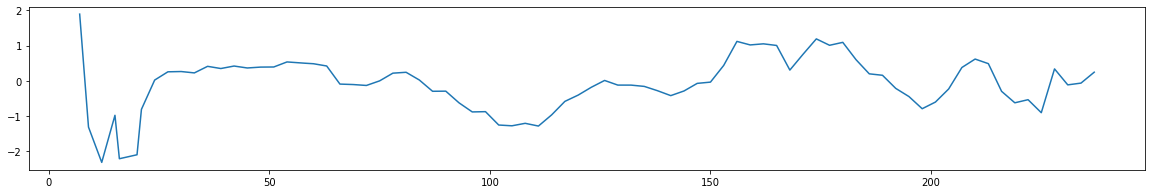

In [ ]:
gdp_data['gdp'].plot(figsize = (20,3))

##### INT_RATE

Przed detekcją anomalii

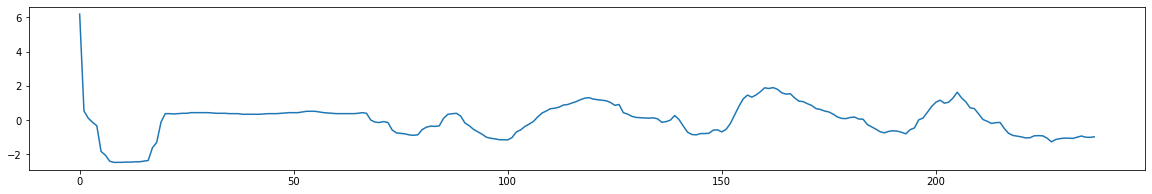

In [ ]:
df['int_rate'].plot(figsize = (20,3))

Po usunięciu outlierów

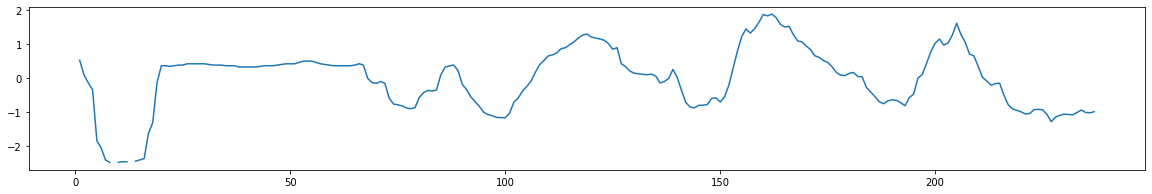

In [ ]:
int_rate_data['int_rate'].plot(figsize = (20,3))
int_rate_data['int_rate'].interpolate(method='linear',inplace = True)

Po interpolacji

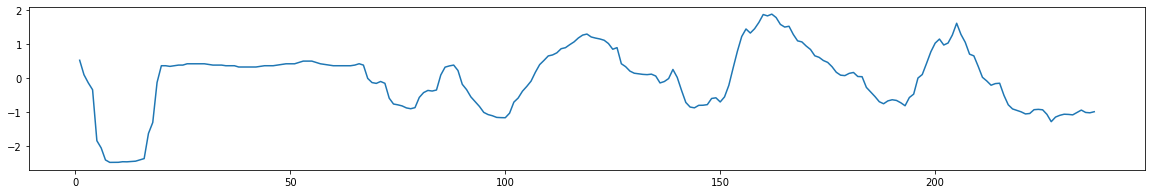

In [ ]:
int_rate_data['int_rate'].plot(figsize = (20,3))

##### INF

Przed detekcją anomalii

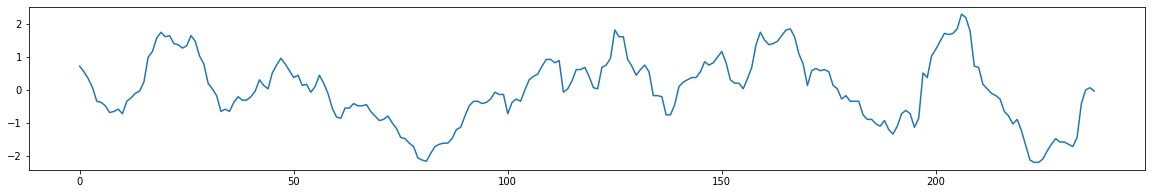

In [ ]:
df['inf'].plot(figsize = (20,3))

Po usunięciu outlierów

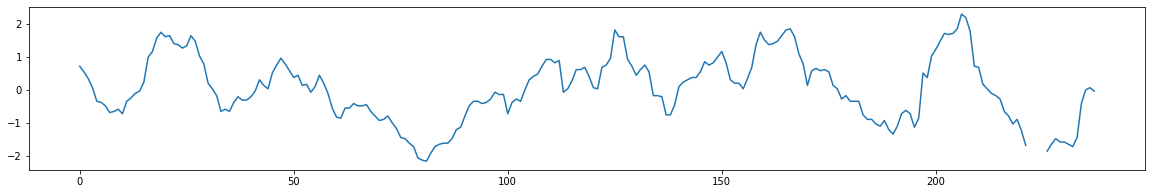

In [ ]:
inf_data['inf'].plot(figsize = (20,3))
inf_data['inf'].interpolate(method='linear',inplace = True)

Po interpolacji

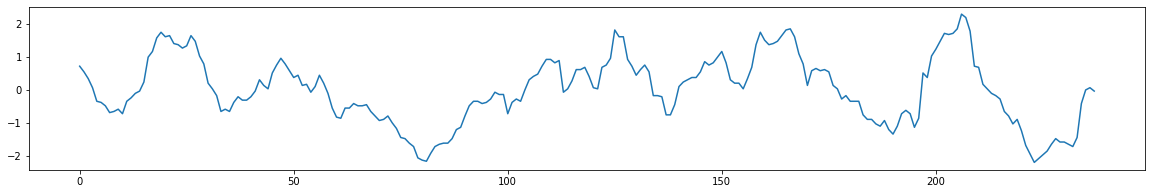

In [ ]:
inf_data['inf'].plot(figsize = (20,3))

Sprawdzam czy zostały jakieś NAN

In [ ]:
print(m3_data.isna().sum())
print('\n')
print(gdp_data.isna().sum())
print('\n')
print(int_rate_data.isna().sum())
print('\n')
print(inf_data.isna().sum())

date    0
m3      0
dtype: int64


date    0
gdp     7
dtype: int64


date        0
int_rate    1
dtype: int64


date    0
inf     0
dtype: int64


Połączmy wszystkie dane za pomocą left merge

In [ ]:
df = m3_data.merge(gdp_data, how = 'left', on = 'date').merge(int_rate_data, how = 'left', on = 'date').merge(inf_data, how = 'left', on = 'date').dropna()
df

,date,m3,gdp,int_rate,inf
7,2002-08-01,1.136293,1.892116,-2.401732,-0.690180
8,2002-09-01,1.577605,0.290888,-2.473604,-0.655858
9,2002-10-01,1.706075,-1.310340,-2.472461,-0.587215
10,2002-11-01,1.609517,-1.643935,-2.471318,-0.724501
11,2002-12-01,1.530836,-1.977531,-2.454330,-0.346965
...,...,...,...,...,...
233,2021-06-01,-1.276436,-0.080093,-1.001534,-1.445253
234,2021-07-01,-1.467822,-0.063366,-0.932929,-0.415608
235,2021-08-01,-1.288390,0.039777,-1.002841,-0.003749
236,2021-09-01,-0.464104,0.142921,-1.012968,0.064894


Zapisanie danych

In [ ]:
df.to_excel('df.xlsx', index = False)

## 3. Opis statystyk opisowych dla zmiennych po transformacji

In [ ]:
import pandas as pd

# df = pd.read_excel('df.xlsx')
df

,date,m3,gdp,int_rate,inf
7,2002-08-01,1.136293,1.892116,-2.401732,-0.690180
8,2002-09-01,1.577605,0.290888,-2.473604,-0.655858
9,2002-10-01,1.706075,-1.310340,-2.472461,-0.587215
10,2002-11-01,1.609517,-1.643935,-2.471318,-0.724501
11,2002-12-01,1.530836,-1.977531,-2.454330,-0.346965
...,...,...,...,...,...
233,2021-06-01,-1.276436,-0.080093,-1.001534,-1.445253
234,2021-07-01,-1.467822,-0.063366,-0.932929,-0.415608
235,2021-08-01,-1.288390,0.039777,-1.002841,-0.003749
236,2021-09-01,-0.464104,0.142921,-1.012968,0.064894


Poniżej zaprezentowano statystyki opisowe dla zmiennych po transformacji, zatem należy zwrócić uwagę, że zmienne są wystandaryzowane co oczywiście odbije się statystykach.

### podstawowe statystyki

In [ ]:
df.describe()

,m3,gdp,int_rate,inf
count,231.000000,231.000000,231.000000,231.000000
mean,0.007914,-0.084055,-0.010762,-0.000109
std,1.005624,0.721600,0.913166,1.010375
min,-2.282738,-2.311127,-2.473604,-2.200326
25%,-0.685994,-0.453991,-0.689870,-0.707340
50%,-0.097817,-0.047334,0.152666,-0.003749
75%,0.737912,0.390852,0.431661,0.717002
max,2.270126,1.892116,1.892951,2.295792


### Skośność i kurtoza

In [ ]:
from scipy.stats import skew
from scipy.stats import kurtosis

for i in df.iloc[:,1:].columns:
  # df['']
  print('Skośność zmiennej {}: {}'.format(i, round(skew(df['{}'.format(i)]),4)))
print('\n')
for i in df.iloc[:,1:].columns:
  print('Kurtoza zmiennej {}: {}'.format(i, round(kurtosis(df['{}'.format(i)]),4)))

Skośność zmiennej m3: 0.1422
Skośność zmiennej gdp: -0.6588
Skośność zmiennej int_rate: -0.5209
Skośność zmiennej inf: -0.0466


Kurtoza zmiennej m3: -0.4092
Kurtoza zmiennej gdp: 0.7833
Kurtoza zmiennej int_rate: 0.3852
Kurtoza zmiennej inf: -0.5876


* **Zmienna m3**

  Zmienna ma umiarkowaną skośność prawostronną oraz jest platykurtyczna, spłaszczona względem rozkładu normalnego

* **Zmienna gdp**

Zmienna jeśt lewoskośna oraz wyraźnie leptokurtyczna, tj. bardziej wydłużona i wąska względem rozkładu normalnego

* **Zmienna int_rate**

Zmienna umiarkowanie prawoskośna i silnie spłaszczona

* **Zmienna inf**

Zmienna delikatnie lewoskośna oraz umiarkowanie spłaszczona względem rozkładu normalnego

In [ ]:
def skew_kurto(column):
  import plotly.express as px
  import plotly.figure_factory as ff
  import plotly.graph_objects as go

  data = [list(column)]
  name = column.name

  fig1 = ff.create_distplot(data, ['{} distplot'.format(name)], bin_size = 0.2, curve_type = 'kde')

  fig2 = ff.create_distplot(data, ['Normal distribution'], bin_size = 0.2, curve_type = 'normal')
  normal_x = fig2.data[1]['x']
  normal_y = fig2.data[1]['y']

  fig1.update_layout(template = 'plotly_dark')

  fig1.add_traces(go.Scatter(x=normal_x, y=normal_y, mode = 'lines',
                          line = dict(color='rgba(0,255,0, 0.6)',
                                      width = 1),
                          name = 'normal'
                         ))
  
  return fig1.show()

In [ ]:
skew_kurto(df['m3'])

In [ ]:
skew_kurto(df['gdp'])

In [ ]:
skew_kurto(df['int_rate'])

In [ ]:
skew_kurto(df['inf'])

### Test JB

Przyjmuję poziom istotności na poziomie równym 0.05

In [ ]:
def jbtest(column):
  from scipy import stats
  jarque_bera_test = stats.jarque_bera(column)
  statistic = jarque_bera_test[0]
  p_value = jarque_bera_test[1]
  return print('statistic: ',jarque_bera_test[0],'\npvalue: ',jarque_bera_test[1], '\nBrak podstaw do odrzucenia H0, p-value jest większe od poziomu istotności 0.05, rozkład zmiennej jest zbliżony do rozkładu normalnego' if p_value > 0.05 else '\nOdrzucamy H0 na rzecz H1, p-value jest mniejsze od poziomu istotności 0.05, rozkład zmiennej nie jest zbliżony do rozkładu normalnego')

M3

In [ ]:
jbtest(df['m3'])

statistic:  2.390142113647385 
pvalue:  0.3026824457648085 
Brak podstaw do odrzucenia H0, p-value jest większe od poziomu istotności 0.05, rozkład zmiennej jest zbliżony do rozkładu normalnego


GDP

In [ ]:
jbtest(df['gdp'])

statistic:  22.613233639242647 
pvalue:  1.2291325114932583e-05 
Odrzucamy H0 na rzecz H1, p-value jest mniejsze od poziomu istotności 0.05, rozkład zmiennej nie jest zbliżony do rozkładu normalnego


INT_RATE

In [ ]:
jbtest(df['int_rate'])

statistic:  11.874157411231554 
pvalue:  0.002639729826214965 
Odrzucamy H0 na rzecz H1, p-value jest mniejsze od poziomu istotności 0.05, rozkład zmiennej nie jest zbliżony do rozkładu normalnego


INF

In [ ]:
jbtest(df['inf'])

statistic:  3.407469554757289 
pvalue:  0.1820025142612256 
Brak podstaw do odrzucenia H0, p-value jest większe od poziomu istotności 0.05, rozkład zmiennej jest zbliżony do rozkładu normalnego


In [ ]:
df.head()

,date,m3,gdp,int_rate,inf
7,2002-08-01,1.136293,1.892116,-2.401732,-0.690180
8,2002-09-01,1.577605,0.290888,-2.473604,-0.655858
9,2002-10-01,1.706075,-1.310340,-2.472461,-0.587215
10,2002-11-01,1.609517,-1.643935,-2.471318,-0.724501
11,2002-12-01,1.530836,-1.977531,-2.454330,-0.346965


Mimo braku rozkłądu normalnego wśród zmiennych postanawiam kontynuować z obecnym stanem zmiennych. Nie uważam, żeby miało to silny wpływ na model VAR

### Autokorelacja

Poniżej zaprezentowano wykresy Autocorrelation Function i Partial Autocorrelation Function dla 25 opóźnień. Poniższe wykresy są jedynie zobrazowaniem występowania bądź też braku autokorelacji. Do dobrania optymalnego hiperparamteru funkcji VAR wykorzystam gridsearch. Następnie każdy z modeli zostanie przetestowany m.in. przez Kryterium informacyjne Akaike (AIC)

In [ ]:
def acf_pacf(col):
  from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
  acf_plot = plot_acf(col, lags = 25)
  pacf_plot = plot_pacf(col, method = 'ols')

  return(col.name,acf_plot,'\n',pacf_plot,'\n')

from pandas.plotting import lag_plot

M3

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lb # Ljung Box test
lb(df[['m3']], lags = 25)

(array([ 213.64440866,  411.14227783,  591.24534145,  751.64361457,
         891.52263055, 1014.0079866 , 1118.58205651, 1205.1180772 ,
        1275.66379906, 1332.224297  , 1377.35817759, 1412.12557672,
        1443.38872959, 1471.24775142, 1495.26725402, 1517.1491316 ,
        1536.31610506, 1551.62556161, 1563.15431903, 1571.91351578,
        1578.18853334, 1582.63144665, 1585.43039783, 1586.612387  ,
        1587.00258173]),
 array([2.20186595e-048, 5.26730820e-090, 7.96639790e-128, 2.28454094e-161,
        1.81885671e-190, 8.34967069e-216, 2.83434825e-237, 7.51529649e-255,
        5.57621027e-269, 4.24384586e-280, 9.23706795e-289, 3.38021645e-295,
        6.87323655e-301, 7.39204023e-306, 5.21762723e-310, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000]))

Wg testu LB możemy stwierdzić, że zachodzi autokorelacja, ponieważ p-value dla wszystkich opóźnień są bliskie zeru tj. możemy odrzucić H0 na rzecz H1

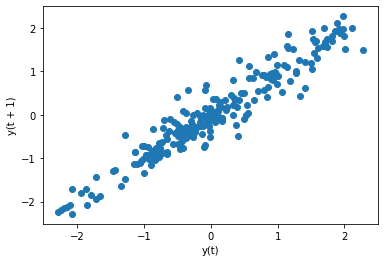

In [ ]:
lag_plot(df['m3'])

Zauważalna autokorelacja oraz niestacjonarność zmiennej

('m3',
 <Figure size 432x288 with 1 Axes>,
 '\n',
 <Figure size 432x288 with 1 Axes>,
 '\n')

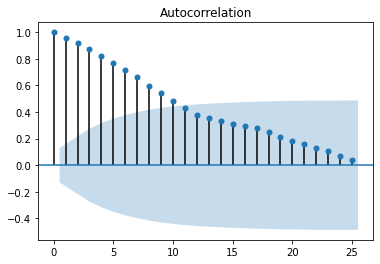

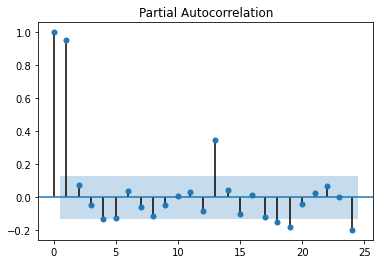

In [ ]:
acf_pacf(df['m3'])

GDP

In [ ]:
lb(df[['gdp']], lags = 25)

(array([ 204.09065755,  374.37025285,  517.63718808,  636.08362817,
         732.90426559,  817.37573228,  889.51514904,  945.0200752 ,
         980.57730448, 1003.71005493, 1017.82566527, 1026.05567729,
        1031.84410245, 1037.38109493, 1041.9475457 , 1045.87774269,
        1049.30313061, 1052.13235002, 1054.45184813, 1056.27313104,
        1057.59766259, 1058.47793346, 1058.99160047, 1059.23289941,
        1059.31230053]),
 array([2.67425500e-046, 5.08782891e-082, 7.18293882e-112, 2.39906897e-136,
        3.76727227e-156, 2.71015238e-173, 8.81889808e-188, 1.09481355e-198,
        2.65696597e-205, 2.96962173e-209, 2.79803527e-211, 4.68391569e-212,
        2.52661246e-212, 1.48839456e-212, 1.36954880e-212, 1.67147946e-212,
        2.53979980e-212, 5.03277862e-212, 1.24765649e-211, 3.85129845e-211,
        1.48035696e-210, 6.90972443e-210, 3.77231658e-209, 2.30152798e-208,
        1.48757525e-207]))

Wg testu LB możemy stwierdzić, że zachodzi autokorelacja, ponieważ p-value dla wszystkich opóźnień są bliskie zeru tj. możemy odrzucić H0 na rzecz H1

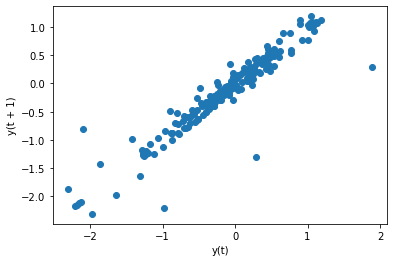

In [ ]:
lag_plot(df['gdp'])

Zauważalna autokorelacja oraz niestacjonarność zmiennej

('gdp',
 <Figure size 432x288 with 1 Axes>,
 '\n',
 <Figure size 432x288 with 1 Axes>,
 '\n')

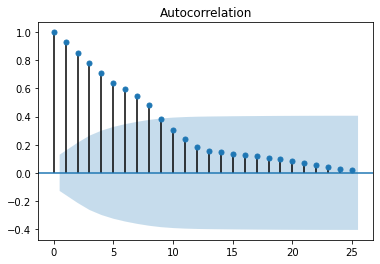

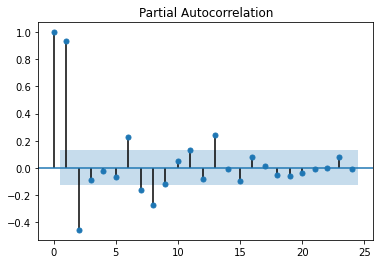

In [ ]:
acf_pacf(df['gdp'])

INT_RATE

In [ ]:
lb(df[['int_rate']], lags = 40)

(array([ 216.66022422,  407.36312176,  567.60786978,  697.37561346,
         797.55347888,  869.71825496,  917.34842219,  945.24307873,
         958.65572835,  962.84226617,  963.22843199,  963.603094  ,
         965.52287536,  969.25924425,  975.05269422,  983.17822404,
         993.73887932, 1006.4466649 , 1020.78307787, 1036.25545857,
        1052.43987395, 1068.93150651, 1085.27756708, 1101.22054777,
        1116.60193804, 1131.09254842, 1144.25909649, 1155.67729248,
        1164.95099768, 1172.02018872, 1176.95538654, 1179.91720807,
        1181.2868033 , 1181.66186106, 1181.66791668, 1181.85682489,
        1182.72612964, 1184.67224087, 1187.9479999 , 1192.72262666]),
 array([4.84059423e-049, 3.48515457e-089, 1.05985028e-122, 1.28970421e-149,
        3.91339469e-170, 1.32052039e-184, 8.60744243e-194, 9.79991540e-199,
        1.41351298e-200, 1.88349170e-200, 1.56661418e-199, 1.24717528e-198,
        4.42228791e-198, 6.14547762e-198, 2.98998854e-198, 4.47262255e-199,
        1.9658

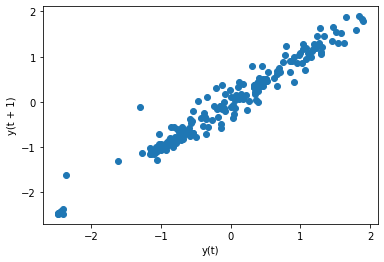

In [ ]:
lag_plot(df['int_rate'])

Zauważalna autokorelacja oraz niestacjonarność zmiennej

('int_rate',
 <Figure size 432x288 with 1 Axes>,
 '\n',
 <Figure size 432x288 with 1 Axes>,
 '\n')

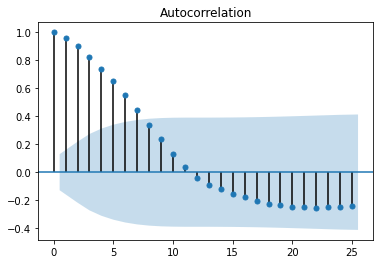

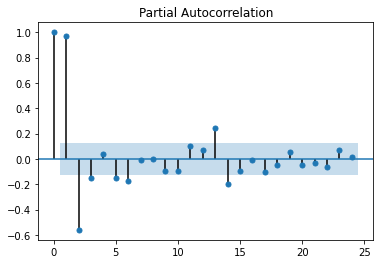

In [ ]:
acf_pacf(df['int_rate'])

INF

In [ ]:
lb(df[['inf']], lags = 40)

(array([ 213.80024347,  398.93559129,  553.09637985,  679.06421388,
         780.75861356,  860.15846539,  919.16776   ,  959.65408961,
         984.22378322,  996.68321126, 1001.25454438, 1002.12265159,
        1002.20448436, 1002.27538966, 1002.7795759 , 1004.14461562,
        1006.56646573, 1010.16075135, 1014.96622466, 1020.59134496,
        1027.05544386, 1034.36691718, 1041.77671337, 1048.66809639,
        1054.63097688, 1059.44905976, 1063.41712595, 1066.32598375,
        1068.31591571, 1069.24137151, 1069.38384898, 1069.42161449,
        1069.98105208, 1071.46348827, 1073.65432453, 1076.18403907,
        1079.10233873, 1082.43024929, 1086.22454417, 1090.09388928]),
 array([2.03608025e-048, 2.35633500e-087, 1.48173552e-119, 1.18915261e-145,
        1.68144578e-166, 1.53832820e-182, 3.48302356e-194, 7.61348028e-202,
        4.34704101e-206, 9.69127290e-208, 1.03088494e-207, 6.55316355e-207,
        5.87787300e-206, 5.08504601e-205, 3.41857536e-204, 1.45139567e-203,
        3.5463

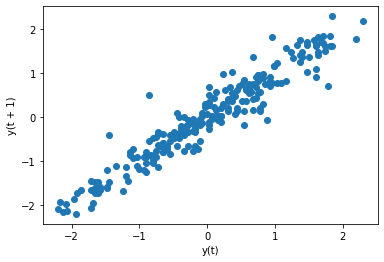

In [ ]:
lag_plot(df['inf'])

('inf',
 <Figure size 432x288 with 1 Axes>,
 '\n',
 <Figure size 432x288 with 1 Axes>,
 '\n')

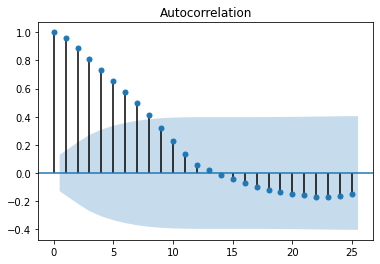

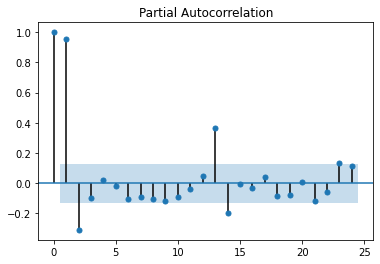

In [ ]:
acf_pacf(df['inf'])

autokorelacja do 7 opóźnienia pozostałe opóźnienia nie są istotne statystycznie. Wykres PACF jednak wykazuje bardziej dokłądne wyniki. Na podstawie tego wykresu możemy stwierdzić korelację pierwszego rzędu z opóźnieniami 1, 2, 13, 14.

### Stacjonarność / Niestacjonarność zmiennych

#### Test ADF

test na stacjonarność

##### M3

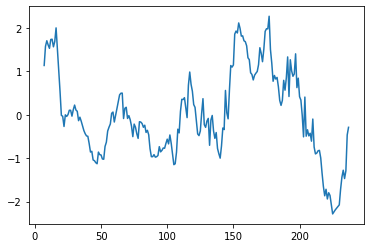

In [ ]:
df['m3'].plot()

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller

pval = adfuller(df['m3'])[1]

print('m3 p-value =',round(pval,4))

m3 p-value = 0.3753


P-value jest większe niż alfa = 0.05, dlatego też nie mamy podstaw do odrzucenia H0. Zmienna nie jest stacjonarna. Ze względu na planowane użycie modelu VAR konieczne jest przeprowadzenie różnicowania.

In [ ]:
from statsmodels.tsa.statespace.tools import diff

m3_diff = diff(df['m3'], k_diff=1)
m3_diff

8      0.441312
9      0.128469
10    -0.096558
11    -0.078680
12     0.204841
         ...   
233    0.159174
234   -0.191386
235    0.179432
236    0.824286
237    0.175855
Name: m3, Length: 230, dtype: float64

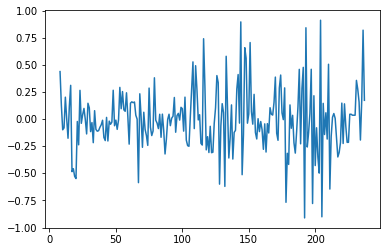

In [ ]:
m3_diff.plot()

In [ ]:
pval = adfuller(m3_diff)[1]
pval

6.061597582919243e-07

Jak możemy zauważyć zmienna jest stacjonarna po dyferencji jedynie jednego okresu. Test ADF wykazuje p-value mniejsze niż przyjęte alfa = 0.05 dlatego też możemy odrzucić H0 na rzecz H1 i stwierdzić, że zmienna jest stacjonarna.

In [ ]:
df['m3_1d'] = m3_diff # przypisanie nowych wartości do dataframe

##### GDP

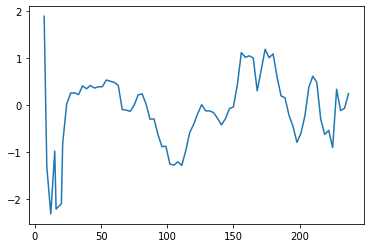

In [ ]:
df['gdp'].plot()

In [ ]:
pval = adfuller(df['gdp'])[1]

print('gdp p-value =',pval)

gdp p-value = 0.2113379840668133


P-value jest bliskie zeru zatem odrzucamy H0 na rzecz H1 i stwierdzamy że zmienna jest stacjonarna. Jednak zintegrowałem zmienną m3 o 1 dlatego zmienna gdp również musi być zintegorwana o 1.

In [ ]:
gdp_diff = diff(df['gdp'], k_diff=1)
gdp_diff

8     -1.601228
9     -1.601228
10    -0.333596
11    -0.333596
12    -0.333596
         ...   
233    0.016727
234    0.016727
235    0.103144
236    0.103144
237    0.103144
Name: gdp, Length: 230, dtype: float64

po różnicowaniu o 1 opóźnienie

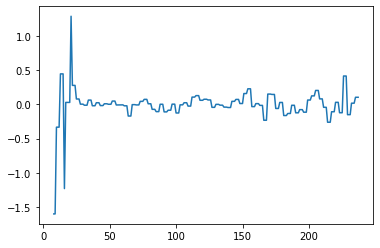

In [ ]:
gdp_diff.plot()

In [ ]:
df['gdp_1d'] = gdp_diff # przypisanie nowych wartości do dataframe

##### INT_RATE

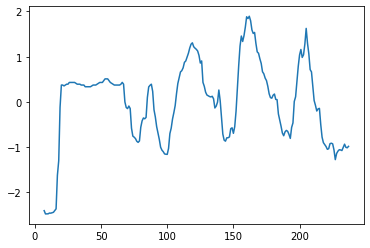

In [ ]:
df['int_rate'].plot()

In [ ]:
pval = adfuller(df['int_rate'])[1]

print('int_rate p-value =',round(pval,4))

int_rate p-value = 0.0309


Na poziomie istotności równym 0.05 oraz za pomocą testu AD Fullera możemy stwierdzic, że nie mamy podstaw do odrzucenia H0 na rzecz H1 zatem zmienna nie jest stacjonarna. Różnicuję zmienną o 1 opóźnienie.

In [ ]:
int_rate_diff = diff(df['int_rate'], k_diff=1)
int_rate_diff

8     -0.071872
9      0.001143
10     0.001143
11     0.016988
12    -0.002614
         ...   
233    0.072199
234    0.068605
235   -0.069912
236   -0.010127
237    0.031689
Name: int_rate, Length: 230, dtype: float64

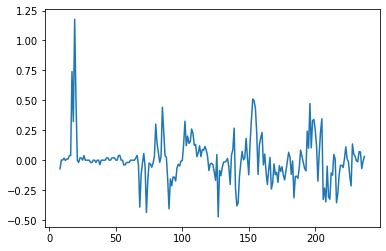

In [ ]:
int_rate_diff.plot()

In [ ]:
pval = adfuller(int_rate_diff)[1]
pval

6.857179326418186e-07

Jak widać differencing o 1 opóźnienie wystarczyło do uzyskania stacjonarności. P-value jest niższe niż 0.05 dlatego odrzucam H0 na rzecz H1 i stwierdzam, że zmienna jest stacjonarna.

In [ ]:
df['int_rate_1d'] = int_rate_diff # przypisanie nowych wartości do dataframe

##### INF

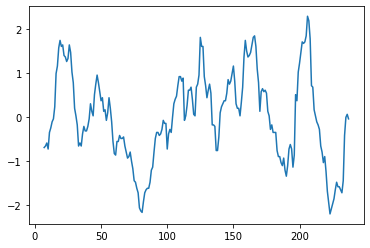

In [ ]:
df['inf'].plot()

In [ ]:
pval = adfuller(df['inf'])[1]

print('inf p-value =',round(pval,4))

inf p-value = 0.0323


Z przyjętym poziomem istotności 0.05 nie możemy odrzucić H0 i stwierdzamy, że zmienna nie jest stacjonarna. Użyję differencing z 1 opóźnieniem

In [ ]:
inf_diff = diff(df['inf'], k_diff=1)
inf_diff

8      0.034322
9      0.068643
10    -0.137286
11     0.377537
12     0.102965
         ...   
233    0.274572
234    1.029645
235    0.411858
236    0.068643
237   -0.102965
Name: inf, Length: 230, dtype: float64

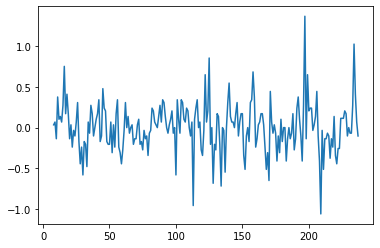

In [ ]:
inf_diff.plot()

In [ ]:
pval = adfuller(inf_diff)[1]
pval

1.0080510605572721e-05

Dzięki różnicowaniu o 1 opóźnienie mogliśmy pozbyć się niestacjonarności. p-value jest mniejsze od 0.05 zatem na podstawie testu ADF stwierdzam, że zmienna jest stacjonarna

In [ ]:
df['inf_1d'] = inf_diff # przypisanie nowych wartości do dataframe

Tworzę df_1d dla wartości zróżnicowanych i df dla wartości oryginalnych

In [ ]:
df_1d = df[['date','m3_1d','gdp_1d','int_rate_1d','inf_1d']]
df_1d.dropna(axis = 0, inplace = True)
df_1d

,date,m3_1d,gdp_1d,int_rate_1d,inf_1d
8,2002-09-01,0.441312,-1.601228,-0.071872,0.034322
9,2002-10-01,0.128469,-1.601228,0.001143,0.068643
10,2002-11-01,-0.096558,-0.333596,0.001143,-0.137286
11,2002-12-01,-0.078680,-0.333596,0.016988,0.377537
12,2003-01-01,0.204841,-0.333596,-0.002614,0.102965
...,...,...,...,...,...
233,2021-06-01,0.159174,0.016727,0.072199,0.274572
234,2021-07-01,-0.191386,0.016727,0.068605,1.029645
235,2021-08-01,0.179432,0.103144,-0.069912,0.411858
236,2021-09-01,0.824286,0.103144,-0.010127,0.068643


In [ ]:
df = df[['date','m3','gdp','int_rate','inf']]
df

,date,m3,gdp,int_rate,inf
7,2002-08-01,1.136293,1.892116,-2.401732,-0.690180
8,2002-09-01,1.577605,0.290888,-2.473604,-0.655858
9,2002-10-01,1.706075,-1.310340,-2.472461,-0.587215
10,2002-11-01,1.609517,-1.643935,-2.471318,-0.724501
11,2002-12-01,1.530836,-1.977531,-2.454330,-0.346965
...,...,...,...,...,...
233,2021-06-01,-1.276436,-0.080093,-1.001534,-1.445253
234,2021-07-01,-1.467822,-0.063366,-0.932929,-0.415608
235,2021-08-01,-1.288390,0.039777,-1.002841,-0.003749
236,2021-09-01,-0.464104,0.142921,-1.012968,0.064894


##### Podsumowanie

Wykres zmiennych przed różnicowaniem

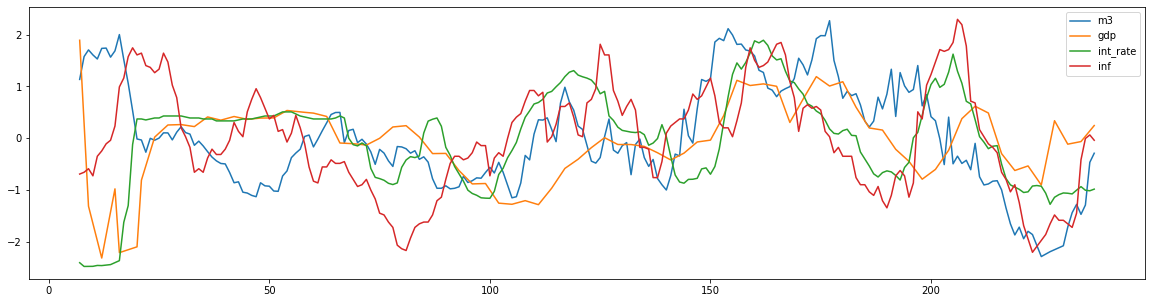

In [ ]:
for i in df.columns[1:]:  
  df['{}'.format(i)].plot(legend = True, figsize = (20,5))

Wykres zmiennych po różnicowaniu

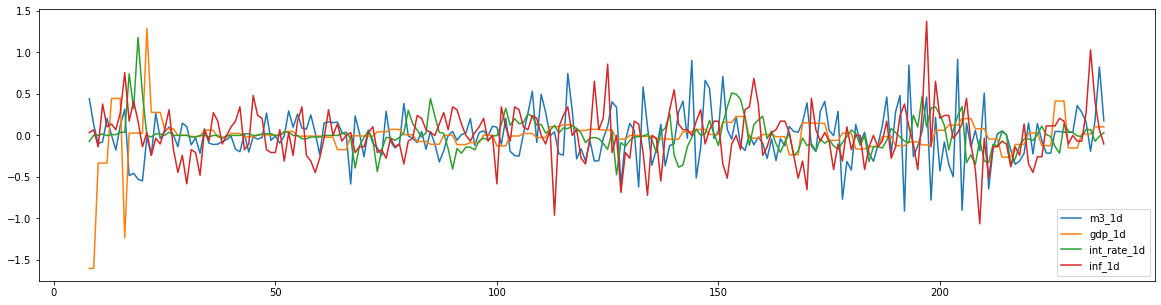

In [ ]:
for i in df_1d.columns[1:]:  
  df_1d['{}'.format(i)].plot(legend = True, figsize = (20,5))

## 4. Dobór dynamicznej specyfikacji modelu

Do modelu użyję oczywiście df_1d ze zmiennymi stacjonarnymi

In [ ]:
df_1d = df_1d.set_index('date').dropna()
df = df.set_index('date')
df_1d

,m3_1d,gdp_1d,int_rate_1d,inf_1d
date,,,,
2002-09-01,0.441312,-1.601228,-0.071872,0.034322
2002-10-01,0.128469,-1.601228,0.001143,0.068643
2002-11-01,-0.096558,-0.333596,0.001143,-0.137286
2002-12-01,-0.078680,-0.333596,0.016988,0.377537
2003-01-01,0.204841,-0.333596,-0.002614,0.102965
...,...,...,...,...
2021-06-01,0.159174,0.016727,0.072199,0.274572
2021-07-01,-0.191386,0.016727,0.068605,1.029645
2021-08-01,0.179432,0.103144,-0.069912,0.411858


In [ ]:
df_1d.shape

(230, 4)

In [ ]:
df.shape

(231, 4)

### VAR

TRAIN TEST SPLIT

Chcemy przeprowadzić predykcje ex-post na 3 lata wstecz zatem stworzę zestaw treningowy do 2018-10, oraz zestaw testowy od 2018-11

In [ ]:
train_1d = df_1d[:-36]
train_1d

,m3_1d,gdp_1d,int_rate_1d,inf_1d
date,,,,
2002-09-01,0.441312,-1.601228,-0.071872,0.034322
2002-10-01,0.128469,-1.601228,0.001143,0.068643
2002-11-01,-0.096558,-0.333596,0.001143,-0.137286
2002-12-01,-0.078680,-0.333596,0.016988,0.377537
2003-01-01,0.204841,-0.333596,-0.002614,0.102965
...,...,...,...,...
2018-06-01,0.462808,-0.114884,0.103561,1.372860
2018-07-01,-0.778081,-0.114884,0.329631,-0.137286
2018-08-01,0.217996,0.062866,0.341066,0.652109


In [ ]:
test_1d = df_1d[-36:]
test_1d

,m3_1d,gdp_1d,int_rate_1d,inf_1d
date,,,,
2018-11-01,-0.349496,0.123648,-0.175107,0.240251
2018-12-01,-0.496942,0.123648,0.058478,-0.034322
2019-01-01,0.915996,0.123648,0.236198,0.034322
2019-02-01,-0.900995,0.203077,0.346293,0.137286
2019-03-01,0.147634,0.203077,-0.328651,0.446180
2019-04-01,-0.140393,0.203077,-0.232931,-0.102965
2019-05-01,0.060678,0.079685,-0.348906,-0.411858
2019-06-01,-0.182334,0.079685,-0.049984,-1.063967
2019-07-01,0.509052,0.079685,-0.305783,-0.034322


Gridsearch dla optymalnej wartości p dla modelu Autoregresji (AR) w modelu Wektorowej Autoregresji (VAR).

In [ ]:
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

model = VAR(train_1d)
aic_df = pd.DataFrame(data = [], columns = ['p','aic'])
for p in range(1,25): 
  results = model.fit(p)
  aic = results.aic

  aic_df.loc[-1] = [p, aic]  # adding a row
  aic_df.index = aic_df.index + 1  # shifting index
  aic_df = aic_df.sort_index()  # sorting by index

In [ ]:
sorted_order = model.select_order(maxlags=24)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.58      -13.51   1.266e-06      -13.55
1       -14.78     -14.41*   3.804e-07     -14.63*
2       -14.75      -14.08   3.937e-07      -14.48
3       -14.75      -13.79   3.940e-07      -14.36
4       -14.73      -13.48   4.002e-07      -14.22
5       -14.78      -13.23   3.823e-07      -14.15
6       -14.81      -12.96   3.736e-07      -14.06
7       -14.84      -12.70   3.649e-07      -13.97
8       -14.78      -12.35   3.884e-07      -13.79
9       -14.75      -12.02   4.022e-07      -13.65
10      -14.76      -11.73   4.043e-07      -13.53
11      -14.72      -11.40   4.267e-07      -13.37
12      -15.10      -11.49   2.953e-07      -13.64
13      -15.23      -11.31  2.661e-07*      -13.64
14      -15.22      -11.01   2.739e-07      -13.51
15      -15.13      -10.63   3.067e-07      -13.30
16      -15.13      -10.33   3.

Powyżej widzimy podsumowanie parametrów dla każdego z opóźnień. Program wstawia gwiazdkę przy najniższej wartości. 5 opóźnienie ma najniższe wartości BIC oraz HQIC. Sprawdźmy jak bardzo odbiega 5 opóźnienie jeżeli chodzi o AIC. 

In [ ]:
px.scatter(aic_df, x = 'p', y = 'aic', template = t, title = 'AIC score per VAR(p)')

Możemy zauważyć, że AIC znacząco spada do 14 opóźnienia (p). Później nadal spada jednak spadek jest powolny. Dzięki AIC możemy stwierdzić, że nie opłaca się bardziej komplikować modelu aniżeli do 5 opóźnienia. Późniejsze opóźnienia faktycznie dają lepszy wyniki modeli ale ich przyrost skomplikowania jest nieproporcjonalny w stosunku do efektywności. Dlatego też dla modelu VAR wybiorę p = 14.

In [ ]:
results = model.fit(14)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Dec, 2021
Time:                     16:51:47
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -10.7835
Nobs:                     180.000    HQIC:                  -13.1881
Log likelihood:           540.874    FPE:                3.97641e-07
AIC:                     -14.8279    Det(Omega_mle):     1.32308e-07
--------------------------------------------------------------------
Results for equation m3_1d
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.003462         0.018120            0.191           0.848
L1.m3_1d               -0.211816         0.088859           -2.384           0.017
L1.gdp_1d               0.211327         0.289680   

#### Ex-post

Pobieram 14 ostatnich opóźnienia zestawu treningowego aby móc przewidzieć kolejne wartości. 

Potrzebujemy matrycy o wymiarach (p,k) gdzie p to wybrane opóźnienie a k to ilość zmiennych (14,4)

Następnie uruchamiamy dopasowanie modelu do danych

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


lagged_values = train_1d.values[-14:] # odpowiednia ilość opóźnień do predykcji ex-post
print('lagged_values shape:',lagged_values.shape,'\n')
z = results.forecast(y = lagged_values, steps = 36) # predykcje na 36 miesięcy


# teraz przekształce wyniki w łatnie wyglądający df
idx = pd.date_range('2018-11-01', periods = 36, freq = 'MS') # do tego potrzebuję indexów. dane sięgają do 2021-10, minus 3 lata to 2018-11
predicted_values = pd.DataFrame(data = z, index = idx, columns = df_1d.columns) # tworzę df

lagged_values shape: (14, 4) 



In [ ]:
z[10]

array([-0.14672696,  0.06940641, -0.0099256 , -0.10336256])

Po przeprowadzeniu predykcji odwracamy transformacje danych

In [ ]:
# Odwracam differencing
nobs = 36
for i in df.columns:
  # Now build the forecast values from the first difference set
  predicted_values['{}_forecast'.format(i)] = df['{}'.format(i)].iloc[-nobs-1] + predicted_values['{}_1d'.format(i)].cumsum()

rescaling - odwrotność standaryzacji

In [ ]:
idx = predicted_values.reset_index()['index']
predicted_values = predicted_values[['m3_forecast','gdp_forecast','int_rate_forecast','inf_forecast']]
predicted_values = pd.DataFrame(data = scaler.inverse_transform(predicted_values), columns = predicted_values.columns)
predicted_values.insert(0, 'date', idx)

In [ ]:
predicted_values = predicted_values.set_index('date')
predicted_values.head()

,m3_forecast,gdp_forecast,int_rate_forecast,inf_forecast
date,,,,
2018-11-01,11.301426,1.694756,23.856770,8.353169
2018-12-01,11.195497,1.900628,25.303140,9.310086
2019-01-01,12.285132,2.024362,27.572987,8.939856
2019-02-01,13.212849,2.400686,35.947575,9.996517
2019-03-01,11.674914,2.478486,35.254547,9.977235


In [ ]:
# to jest nasz właściwy nieróżnicowany zestaw testowy
test = df[-nobs:]
test.head()

,m3,gdp,int_rate,inf
date,,,,
2018-11-01,-0.010512,-0.477341,0.983442,1.712326
2018-12-01,-0.507454,-0.353693,1.041920,1.678005
2019-01-01,0.408542,-0.230045,1.278118,1.712326
2019-02-01,-0.492453,-0.026968,1.624410,1.849612
2019-03-01,-0.344819,0.176109,1.295759,2.295792


Rescaling dla zestawu testowego bez różnicowania

In [ ]:
idx = test.reset_index()['date']
test = test[['m3','gdp','int_rate','inf']]
test = pd.DataFrame(data = scaler.inverse_transform(test), columns = test.columns)
test.insert(0, 'date', idx)
test = test.set_index('date')
test.head()

,m3,gdp,int_rate,inf
date,,,,
2018-11-01,9.384360,2.000103,18.10,7.6
2018-12-01,7.224510,2.355687,19.89,7.5
2019-01-01,11.205689,2.711271,27.12,7.6
2019-02-01,7.289708,3.295277,37.72,8.0
2019-03-01,7.931369,3.879284,27.66,9.3


MSE: 45.26020334878764
RMSE: 6.727570389731173
Mean: 1.5097222222222215 



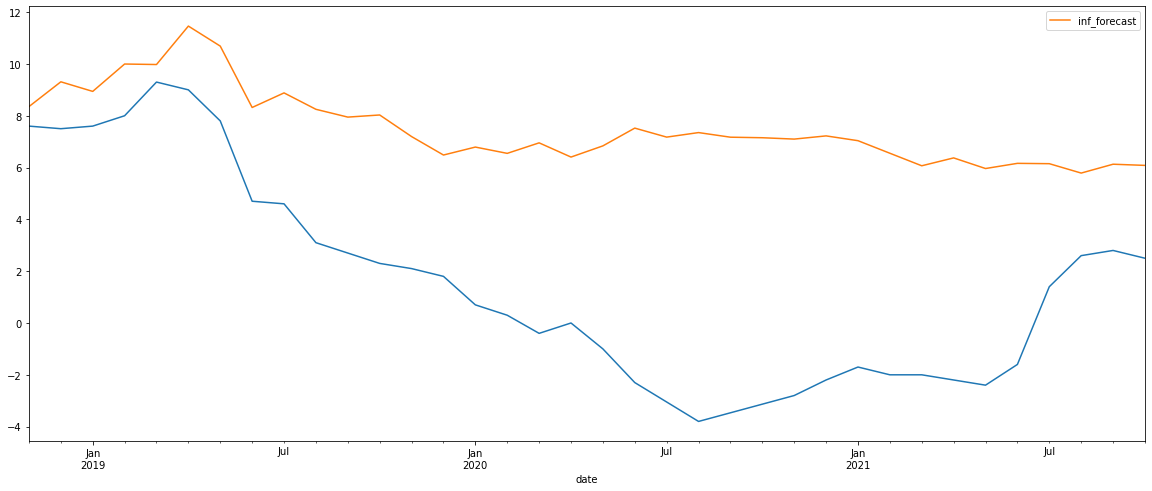

In [ ]:
# sprawdzę wykres dla danych teoretycznych i empirycznych
test['inf'].plot()
predicted_values['inf_forecast'].plot(figsize = (20,8), legend = True)

# sprawdzam mse, rmse i dla porównania średnią z test set
print('MSE:',mean_squared_error(test['inf'], predicted_values['inf_forecast']))
print('RMSE:',rmse(test['inf'],predicted_values['inf_forecast']))
print('Mean:',test['inf'].mean(),'\n')

Wyniki są dosyć nieprecyzyjne, mimo pewnego dopasowania modelu do danych przewiduje on z bardzo małą szczegółowością

## 5. Interpretacja parametrów 

Finalny model

In [ ]:
results.params['inf_1d']

const              0.003414
L1.m3_1d          -0.154410
L1.gdp_1d         -0.546662
L1.int_rate_1d     0.406426
L1.inf_1d          0.196458
L2.m3_1d          -0.241075
L2.gdp_1d          0.878544
L2.int_rate_1d    -0.108996
L2.inf_1d         -0.037621
L3.m3_1d          -0.092866
L3.gdp_1d         -0.206016
L3.int_rate_1d     0.215486
L3.inf_1d         -0.033083
L4.m3_1d          -0.069664
L4.gdp_1d         -0.095869
L4.int_rate_1d    -0.179293
L4.inf_1d         -0.000414
L5.m3_1d          -0.091646
L5.gdp_1d          0.196552
L5.int_rate_1d     0.087413
L5.inf_1d         -0.024341
L6.m3_1d           0.258405
L6.gdp_1d         -0.394061
L6.int_rate_1d     0.207206
L6.inf_1d          0.207467
L7.m3_1d          -0.083134
L7.gdp_1d          0.157373
L7.int_rate_1d    -0.069520
L7.inf_1d         -0.002644
L8.m3_1d           0.073287
L8.gdp_1d         -0.275529
L8.int_rate_1d     0.046677
L8.inf_1d         -0.015472
L9.m3_1d           0.190691
L9.gdp_1d         -0.329306
L9.int_rate_1d    -0

In [ ]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Dec, 2021
Time:                     16:51:48
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -10.7835
Nobs:                     180.000    HQIC:                  -13.1881
Log likelihood:           540.874    FPE:                3.97641e-07
AIC:                     -14.8279    Det(Omega_mle):     1.32308e-07
--------------------------------------------------------------------
Results for equation m3_1d
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.003462         0.018120            0.191           0.848
L1.m3_1d               -0.211816         0.088859           -2.384           0.017
L1.gdp_1d               0.211327         0.289680   

Równanie

inf = L1.inf

żadne opóźnienia zmiennych objaśniających nie są istotne statystycznie

## 6. Weryfikacja statystyczna modelu

### Istotność parametrów

poniżej istotne zmienne objasniajace dla 1 modelu

In [ ]:
pval = results.pvalues[['inf_1d']]
pval[pval['inf_1d']<0.05]

,inf_1d
L1.int_rate_1d,2.022934e-02
L1.inf_1d,2.611452e-02
L2.m3_1d,6.047844e-03
L2.gdp_1d,9.349228e-03
L6.m3_1d,1.735043e-03
L6.inf_1d,1.345073e-02
L9.m3_1d,1.970266e-02
L12.m3_1d,1.850728e-02
L12.inf_1d,2.893403e-09
L13.m3_1d,2.292218e-02


### Dopasowanie do danych

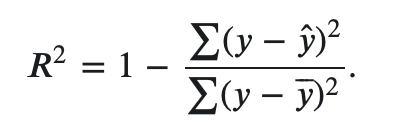

y - wartości empiryczne, y_hat - wartości teoretyczne y_dash - średnia wartości empirycznych

predykcje

In [ ]:
predicted_values[['inf_forecast']].head()

,inf_forecast
date,
2018-11-01,8.353169
2018-12-01,9.310086
2019-01-01,8.939856
2019-02-01,9.996517
2019-03-01,9.977235


dane testowe

In [ ]:
test[['inf']].head()

,inf
date,
2018-11-01,7.6
2018-12-01,7.5
2019-01-01,7.6
2019-02-01,8.0
2019-03-01,9.3


sprwadzam zgodność kształtów

In [ ]:
print(predicted_values.shape)
print(test.shape)

(36, 4)
(36, 4)


In [ ]:
y_hat = predicted_values['inf_forecast'].values
y_hat

array([ 8.35316902,  9.31008633,  8.93985635,  9.99651659,  9.97723508,
       11.46106085, 10.68772233,  8.31904788,  8.8820094 ,  8.24884453,
        7.94768481,  8.02975318,  7.19605528,  6.48369477,  6.79076991,
        6.54801746,  6.95371918,  6.40503351,  6.83709289,  7.52273752,
        7.17541791,  7.35023198,  7.17194812,  7.15129466,  7.09893186,
        7.22234824,  7.03723243,  6.55263024,  6.06875988,  6.37274887,
        5.96266281,  6.16252303,  6.14955578,  5.78717067,  6.12888485,
        6.08382212])

In [ ]:
y = test['inf'].values
y

array([ 7.6       ,  7.5       ,  7.6       ,  8.        ,  9.3       ,
        9.        ,  7.8       ,  4.7       ,  4.6       ,  3.1       ,
        2.7       ,  2.3       ,  2.1       ,  1.8       ,  0.7       ,
        0.3       , -0.4       ,  0.        , -1.        , -2.3       ,
       -3.05      , -3.8       , -3.46666667, -3.13333333, -2.8       ,
       -2.2       , -1.7       , -2.        , -2.        , -2.2       ,
       -2.4       , -1.6       ,  1.4       ,  2.6       ,  2.8       ,
        2.5       ])

In [ ]:
y_dash = test['inf'].values.mean()
y_dash

1.509722222222222

In [ ]:
licznik = []
mianownik = []

for i in range(len(y)):
  licznik.append((y[i]-y_hat[i])**2)
  mianownik.append((y[i]-y_dash)**2)

R_sq = 1 - (sum(licznik) / sum(mianownik))
R_sq

-1.8722217542427093

R_sq jest gorszy niż R_sq modelu liniowego, oznacza to, że lepiej jest zastosować regresję liniową aniżeli oszacowany model.

## 8. Prognoza ex-ante

Przeprowadzę prognozę ex-ante dla roku 2022

model w podejściu pierwszym, który użyję miał p = 14 dlatego teraz stworzę df_init z 14 ostatnimi okresami z df

In [ ]:
df_init = df_1d.values[-14:]
df_init

array([[-0.21256538, -0.12288276,  0.00980074,  0.11440504],
       [-0.21256538, -0.12288276, -0.01306765,  0.11440504],
       [ 0.04712975,  0.41389943, -0.13459679,  0.11440504],
       [ 0.04712975,  0.41389943, -0.21496283,  0.20592907],
       [ 0.03808858,  0.41389943,  0.13557686,  0.17160756],
       [ 0.03808858, -0.15099145,  0.05161722, -0.10296453],
       [ 0.03808858, -0.15099145,  0.03201574,  0.        ],
       [ 0.360153  , -0.15099145, -0.00555375, -0.06864302],
       [ 0.2784498 ,  0.0167272 , -0.01306765, -0.06864302],
       [ 0.15917393,  0.0167272 ,  0.07219876,  0.27457209],
       [-0.19138592,  0.0167272 ,  0.06860516,  1.02964534],
       [ 0.17943152,  0.10314368, -0.06991192,  0.41185814],
       [ 0.82428559,  0.10314368, -0.01012743,  0.06864302],
       [ 0.17585477,  0.10314368,  0.03168905, -0.10296453]])

In [ ]:
z_final = results.forecast(y = df_init, steps = 15) 
idx_final = pd.date_range('2021-10-01', periods = 15, freq = 'MS') 
predicted_values_ante = pd.DataFrame(data = z_final, index = idx_final, columns = df.columns) # tworzę df
predicted_values_ante

,m3,gdp,int_rate,inf
2021-10-01,0.291961,0.003130,0.156096,-0.375038
2021-11-01,0.416619,0.098263,0.156758,-0.015759
2021-12-01,0.021022,0.136568,0.061941,0.291340
2022-01-01,-0.107660,0.230967,0.114111,0.493453
2022-02-01,0.147986,0.192212,0.213539,0.164642
2022-03-01,0.116973,0.134443,0.266264,-0.260363
2022-04-01,-0.078625,0.066930,0.281064,-0.104781
2022-05-01,0.151048,0.062407,0.126026,0.011574
2022-06-01,0.071020,0.065125,0.038678,-0.294681
2022-07-01,-0.217397,0.078253,0.094165,0.094644


In [ ]:
predicted_values_ante.reset_index(inplace = True)
predicted_values_ante.rename(columns = {'index':'date'}, inplace = True)
predicted_values_ante

,date,m3,gdp,int_rate,inf
0,2021-10-01,0.291961,0.003130,0.156096,-0.375038
1,2021-11-01,0.416619,0.098263,0.156758,-0.015759
2,2021-12-01,0.021022,0.136568,0.061941,0.291340
3,2022-01-01,-0.107660,0.230967,0.114111,0.493453
4,2022-02-01,0.147986,0.192212,0.213539,0.164642
5,2022-03-01,0.116973,0.134443,0.266264,-0.260363
6,2022-04-01,-0.078625,0.066930,0.281064,-0.104781
7,2022-05-01,0.151048,0.062407,0.126026,0.011574
8,2022-06-01,0.071020,0.065125,0.038678,-0.294681
9,2022-07-01,-0.217397,0.078253,0.094165,0.094644


Integracja + rescalling

In [ ]:
# Odwracam differencing
nobs = 36
for i in df.columns:
  # Now build the forecast values from the first difference set
  predicted_values_ante['{}_forecast'.format(i)] = df['{}'.format(i)].iloc[-nobs-1] + predicted_values_ante['{}'.format(i)].cumsum()

In [ ]:
idx = predicted_values_ante.reset_index()['date']
predicted_values_ante = predicted_values_ante[['m3_forecast','gdp_forecast','int_rate_forecast','inf_forecast']]
predicted_values_ante = pd.DataFrame(data = scaler.inverse_transform(predicted_values_ante), columns = predicted_values_ante.columns)
predicted_values_ante.insert(0, 'date', idx)
predicted_values_ante

,date,m3_forecast,gdp_forecast,int_rate_forecast,inf_forecast
0,2021-10-01,12.172313,1.653519,28.238083,5.807279
1,2021-11-01,13.983058,1.936101,33.036427,5.761362
2,2021-12-01,14.074425,2.328840,34.932431,6.610216
3,2022-01-01,13.606502,2.993050,38.425358,8.047954
4,2022-02-01,14.249691,3.545810,44.961762,8.527659
5,2022-03-01,14.758087,3.932440,53.112092,7.769059
6,2022-04-01,14.416360,4.124916,61.715449,7.463766
7,2022-05-01,15.072856,4.304385,65.573107,7.497487
8,2022-06-01,15.381527,4.491671,66.757026,6.638897
9,2022-07-01,14.436657,4.716710,69.639413,6.914656


In [ ]:
px.scatter(predicted_values_ante,x = 'date',y = 'inf_forecast', template = t, title = 'Predykcje zmian wskaźnika inflacji Food and non-alcoholic beverages')

## IRF

In [ ]:
irf = results.irf(36)

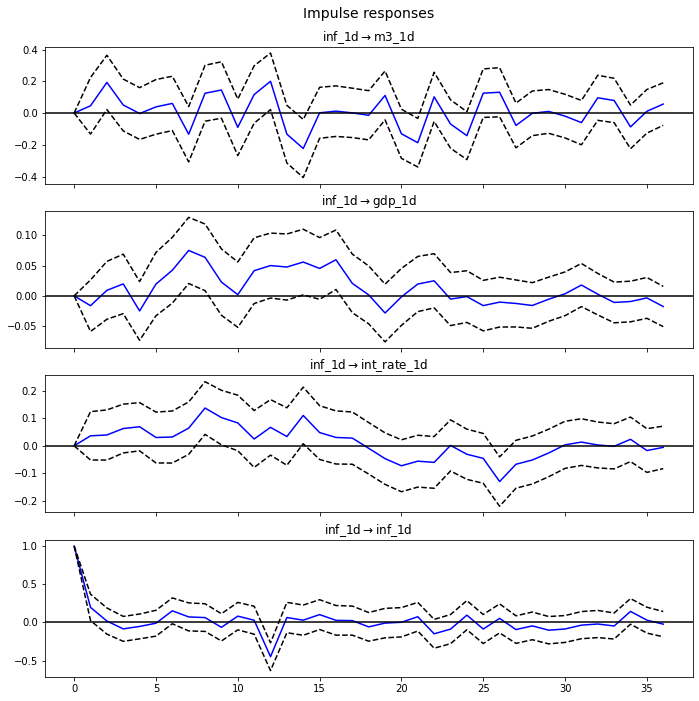

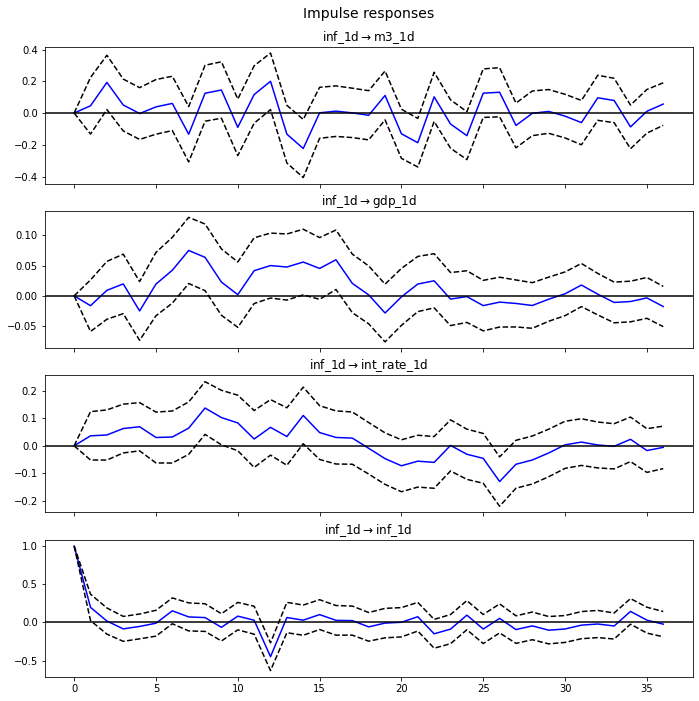

In [ ]:
irf.plot(impulse='inf_1d')

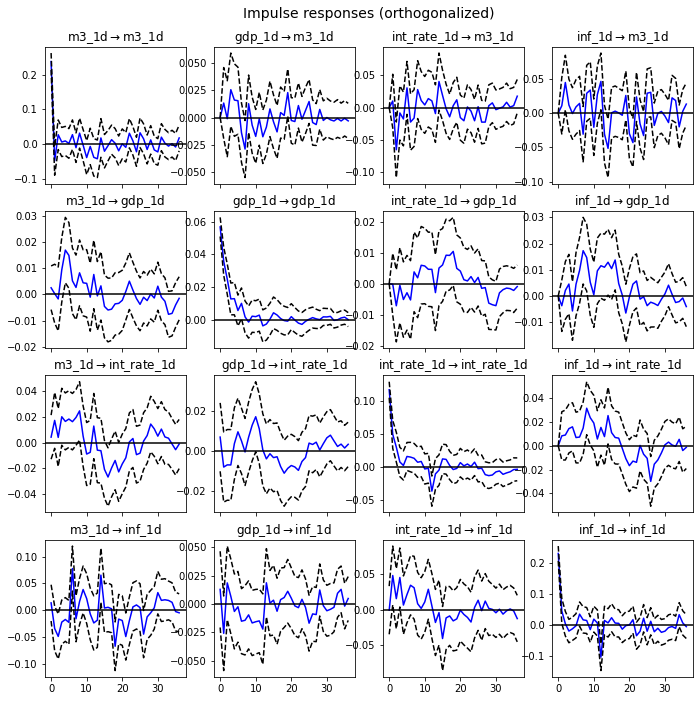

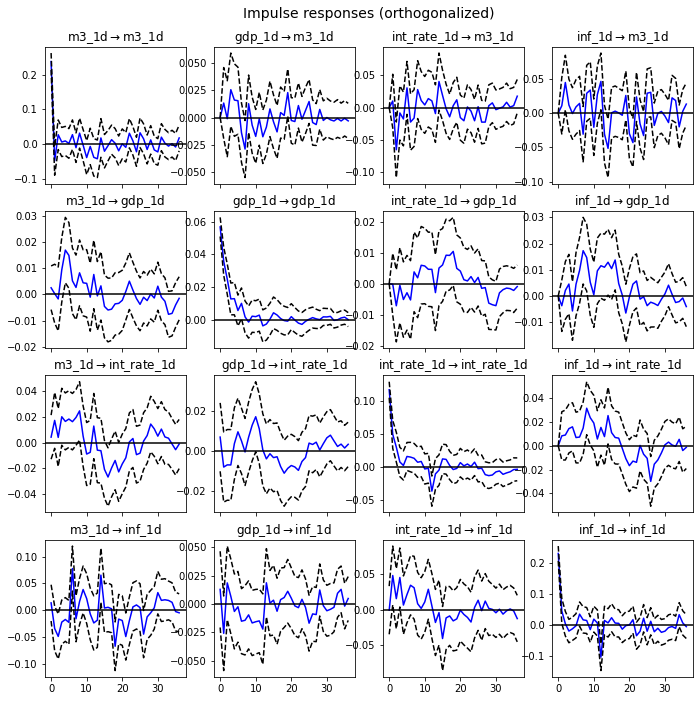

In [ ]:
irf.plot(orth=True)

Nas interesuje ostatni rząd czyli wpływ impulsu każdej ze zmiennych objaśniających na zmienną inf

Domyślny poziom ufności to 95%, domyślnie ortonormalizacja jest przeprowadzaona metodą Cholesky'ego. W ostatnim rzędzie widzimy kolejno impuls (jedno odchylenie standardowe) każdej ze zmiennych objaśniających na zmienną inf. Niebieska linia wyznacza impuls zaś przereywane linie wyznaczają granice przedziału ufności.

## 9. Podsumowanie 

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = df.reset_index()['date'] , y = df.reset_index()['inf'], name = 'known HICP'))
fig.add_trace(go.Scatter(x=predicted_values_ante['date'], y= predicted_values_ante['inf_forecast'], name = 'prediction'))

fig.update_layout(template = t)

fig.show()

Statystyczna ocena modelu jest słaba i należałoby dodać nowe zmienne objaśniające aby predykcja ex-post wykazała lepsze dopasowanie modelu do danych oraz wskaźniki MAE i RMSE. Problem w modelu wynika prawdopodobnie z autokorelacji zmiennych objaśniających oraz zmiennej objaśnianej oraz z braku rozkładu normalnego dwóch zmiennych objaśniających. W kolejnym modelu warto byłoby dodać dodatkowe zmienne objaśniające, zlogarytmować zmienne objaśniające nie mające rozkładu normalnego. To powinno pomóc w uzyskaniu lepszego wyniku przy predykcji ex-post. W przypadku ciągłego problemu ze zmiennymi objaśniającymi najlepiej jest użyć rekurencyjne sieci neuronowe (LSTM), w tym przypadku nie ma znaczenia autokorelacja oraz brak rozkładu normalnego zmiennych. Wówczas należy zmienić jedynie wymiar danych, stworzyć odpowiedni model (proponowany optimizer rmsprop, loss function SGD).



---



# Dodatkowe modele

In [ ]:
train = df_1d[:-36]
test = df_1d[-36:]

In [ ]:
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1:]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1:]

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

Ridge regression

In [ ]:
from sklearn.metrics import r2_score

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(train_X, train_y)
predictions_ridge = ridge.predict(test_X)
r2_score(test_y,predictions_ridge)
print('R^2 ridge regression:',r2_score(test_y,predictions_ridge))

R^2 ridge regression: -0.01916716669786278


Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression 

linear = LinearRegression()
linear.fit(train_X, train_y)
predictions_linear = linear.predict(test_X)
print('R^2 linear model:',r2_score(test_y,predictions_linear))

R^2 linear model: -0.017768766247185486


Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth = 20)
dtr.fit(train_X, train_y)
predictions_dtr = dtr.predict(test_X)
print('R^2 decision tree regressor model:',r2_score(test_y,predictions_dtr))

R^2 decision tree regressor model: -0.8753756466048119
